In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

from PIL import Image 
import albumentations as A
from albumentations.pytorch import ToTensorV2

RANDOM_SEED=42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available:
    torch.cuda.manual_seed(RANDOM_SEED)

In [2]:
# Check device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available:
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f}GB')

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Memory: 4.29GB


In [3]:
# Initial declaration
DATASET_PATH='../../data/food-101/food-101/images'
TRAIN_CSV='../../data/food-101/food-101-preprocessed/train_df.csv'
VAL_CSV='../../data/food-101/food-101-preprocessed/val_df.csv'
TEST_CSV='../../data/food-101/food-101-preprocessed/test_df.csv'

MODEL_NAME='resnet50'
NUM_CLASSES=101
IMG_SIZE=224   
BATCH_SIZE=16
NUM_EPOCHS=10
LEARNING_RATE=0.001
NUM_WORKERS=4

SAVE_MODEL_PATH='../../models'
SAVE_RESULT_PATH='../../results'

In [4]:
# Custom dataset class
class Food101Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df=pd.read_csv(csv_file)
        self.root_dir=root_dir
        self.transform=transform

        self.classes=sorted(self.df['class_name'].unique())
        self.cls_to_idx={cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_cls={idx: cls for idx, cls in enumerate(self.classes)}

        print(f'Dataset loaded: {len(self.df)} images, {len(self.classes)} classes.')

    def __len__(self):
        return(len(self.df))
    
    def __getitem__(self, idx):
        img_path=self.df.iloc[idx]['image_path']
        class_name=self.df.iloc[idx]['class_name']
        label=self.cls_to_idx[class_name]

        img=Image.open(img_path).convert('RGB')
        img=img.resize((IMG_SIZE, IMG_SIZE))
        img=np.array(img)

        if self.transform:
            transformed=self.transform(image=img)
            img=transformed['image']

        return img, label
    
    def get_class_name(self, idx):
        return self.idx_to_cls[idx]

In [5]:
# Augmentation
train_transform=A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),
    A.Affine(translate_percent={'x':0.1, 'y':0.1}, scale=(0.9, 1.1), rotate=(+15, -15), p=0.3),

    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),

    A.GaussNoise(var_limit=(10, 30), p=0.3),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),

    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_test_transform=A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

C:\Users\asus\AppData\Local\Temp\ipykernel_27468\731977300.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 30), p=0.3),


Dataset loaded: 70700 images, 101 classes.
Dataset loaded: 15150 images, 101 classes.
Dataset loaded: 15150 images, 101 classes.

Data loading test
  Batch shape: torch.Size([16, 3, 224, 224])
  Labels shape: torch.Size([16])
  Image range: [-2.12, 2.64]


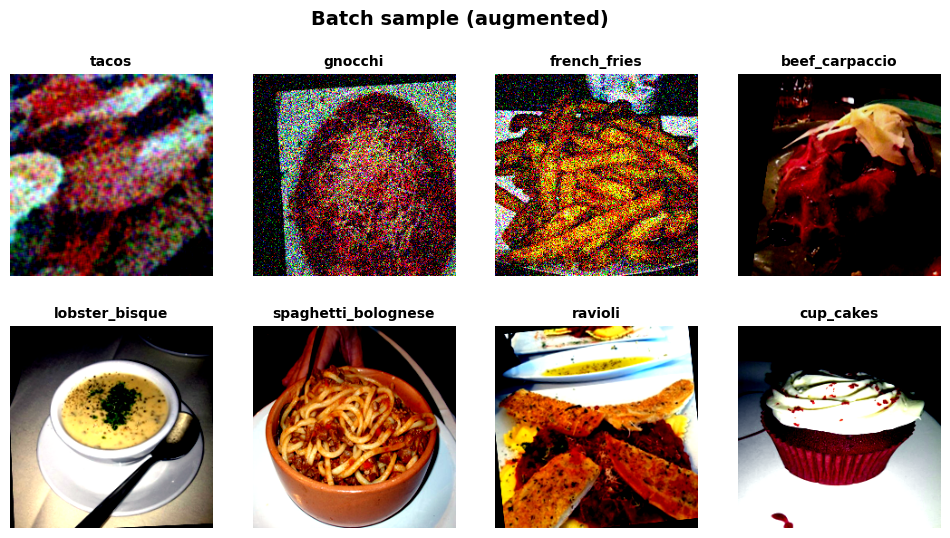

In [23]:
# Load datasets
train_dataset=Food101Dataset(
    csv_file=TRAIN_CSV,
    root_dir='',
    transform=train_transform
)

val_dataset=Food101Dataset(
    csv_file=VAL_CSV,
    root_dir='',
    transform=val_test_transform
)

test_dataset=Food101Dataset(
    csv_file=TEST_CSV,
    root_dir='',
    transform=val_test_transform
)

# DataLoaders
train_loader=DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader=DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

test_loader=DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

print("\nData loading test")
images, labels = next(iter(train_loader))
print(f"  Batch shape: {images.shape}")
print(f"  Labels shape: {labels.shape}")
print(f"  Image range: [{images.min():.2f}, {images.max():.2f}]")

# Batch viz
fig, ax=plt.subplots(2, 4, figsize=(12, 6))
ax=ax.flatten()

mean=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])

for i in range(8):
    img=images[i].permute(1, 2, 0).cpu().numpy()
    img=img * mean + std
    img=np.clip(img, 0, 1)

    ax[i].imshow(img)
    class_name=train_dataset.get_class_name(labels[i].item())
    ax[i].set_title(f'{class_name}', fontsize=10, fontweight='bold')
    ax[i].axis('off')

plt.suptitle(f'Batch sample (augmented)', fontsize=14, fontweight='bold')
plt.savefig('figures/batch_sample', dpi=300, bbox_inches='tight')
plt.show()